In [4]:
import sys
!{sys.executable} -m pip install pennylane
!{sys.executable} -m pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 6.7 MB/s 
     |████████████████████████████████| 9.3 MB 27.1 MB/s 
     |████████████████████████████████| 1.6 MB 47.5 MB/s 
     |████████████████████████████████| 108 kB 48.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np 
import matplotlib.pyplot as plt

# Space debris optimization

In this work, we solve the combinatorial optimization problem of space debris collection. A challenge for space agencies, satellite producers and any actor involved in space travel is to avoid space debris. In spite of possibly small sizes, their speeds on orbits make any collision with satellite or spacecraft threaten the success of space expeditions with major damage. Therefore, a major concern is to collect these debris and destroy them at the entrance of the atmosphere.

The problem is the following. Debris collection journeys are expensive, since the quantity of fuels used to propel the engins is massive, and the capacity of each space craft limits the amount of space garbage that can be collected. To optimize each trip to space, we must therefore seek debris located at particular locations, such that they minimize the distance and hence the fuel consumption, and they maximize the quantity of trash collected. We solve the latter problem first, and add further constraints to the problem progressively.

### Formulation of the cost function 

Let us first consider the problem of maximization of the volume of trash that is collected. This task is related to the knapsack problem. 

We start with a set of N debris. We encode the information about the debris to collect in a bitstring:
\begin{equation}
z = z_1 z_2 \cdots z_N, \text{where } z_i = \begin{cases}
1, & \text{if debris i is collected} \\
0, & \text{if otherwise.}
\end{cases}
\end{equation}

To solve the problem with brute force method, we must inspect all possible bitstrings $z$ and pick the one that maximizes the volume of the debris collected. Therefore, it is a combinatorial optimization problem. To formulate it, we pair each debris $i$ with its weight/size $w_i$. The debris locations can be reported on a graph with edge set $E$ and vertex set $V$ such that $G = \{E,V\}$. Each vertex is associated with a weight, and each edge $i -j$ with a distance $d_{ij}$. With these notations, we encode the problem into the cost function:
\begin{equation}
C(z) = (V-\sum_{i=1}^{N} w_i z_i)^2 + \sum_{i, j=1}^{N} d_{ij} z_i z_j
\end{equation}
where the first term corresponds to the knapsack problem and the second aims at minimizing the travelled distance. To simplify the implementation, the constant term can be removed:
\begin{align}
C(z) &=  (-2V\sum_{i=1}^{N} w_i z_i + 2\sum_{i<j = 1}^N w_i w_j z_i z_j) + \sum_{i<j=1}^{N} d_{ij} z_i z_j \\
 & = -2V \sum_{i=1}^{N} w_i z_i + \sum_{i<j = 1}^N (2 w_i w_j + d_{ij})\, z_i z_j
\end{align}

### Mapping to a Hamiltonian

The next step is to transform the bits $z_i$ into quantum operators. To preserve the mapping to 0 and 1, one can perform the following mapping:
\begin{equation}
z_i \longrightarrow \frac{1}{2}(\mathbb{1}_i - Z_i)
\end{equation}
where Z_i is the Pauli Z operator acting on qubit $i$. By simply inserting this ansatz into the cost function, we can construct the problem Hamiltonian:
\begin{align}
\hat{H}_P &=  -2V \sum_{i=1}^{N} w_i \frac{1}{2}(\mathbb{1}_i - Z_i) + \sum_{i<j}^N (2 w_i w_j + d_{ij})\, \frac{1}{4}(\mathbb{1}_i - Z_i) (\mathbb{1}_i - Z_j) \\
&= -2V \sum_{i=1}^{N} w_i \frac{1}{2}(\mathbb{1}_i - Z_i) + \sum_{i<j}^N (2 w_i w_j + d_{ij})\, \frac{1}{4}(\mathbb{1}_i \mathbb{1}_j - Z_i - Z_j + Z_iZ_j). 
\end{align}
Since the terms acting with the identity only shift all energy levels irrespective of the states, we can omit them in the formulation. The final Hamiltonian is therefore:
\begin{align}
\hat{H}_P &= \sum_{i=1}^{N} Vw_i Z_i + \sum_{i<j} (2 w_i w_j + d_{ij})\, \frac{1}{4}( - Z_i - Z_j + Z_iZ_j)\\
&= \sum_{i=1}^{N} h_i Z_i + \sum_{i<j}^N g_{ij} ( - Z_i - Z_j + Z_iZ_j)\\
&= \sum_{i=1}^{N} (h_i - \sum_{j>i} g_{ij} -\sum_{j<i} g_{ij})\, Z_i + \sum_{i<j} g_{ij} Z_iZ_j\\
&= \sum_{i=1}^{N} (h_i - \sum_{j \not= i} g_{ij}) \, Z_i + \sum_{i<j} g_{ij} Z_iZ_j,
\end{align}
where we have defined $h_i = Vw_i$ and $g_{ij} = \frac{1}{4} (2w_i w_j+d_{ij}) 

### Potentially wrong Hamiltonian WARNING

The second step is to convert this cost function into a Hamiltonian with $\hat{Z}$ operators acting on one and two qubits (Ising Hamiltonian). We realize the following mapping:
\begin{equation}
z_i \longrightarrow \hat{Z_i} 
\end{equation}
where the quantum operator acts as:
\begin{equation}
\hat{Z_i} |z_i\rangle = 
\begin{cases}
-1, & \text{if } |z_i\rangle = |1\rangle \\
1, & \text{if } |z_i\rangle = |0\rangle.
\end{cases}
\end{equation}

The resulting problem Hamiltonian is:
\begin{equation}
\hat{H}_P = -2V \sum_{i=1}^{N} w_i \hat{Z_i} + \sum_{i<j = 1}^N (2 w_i w_j + d_{ij})\, \hat{Z_i} \hat{Z_j}.
\end{equation}



$C(z) = \sum_{i, j=1}^{N} d_{ij} z_i z_j + \gamma (V-\sum_{i=1}^{N} w_i z_i)^2$

Further possible optimization terms in the cost function:
- Check in the solution whether $\sum_{i,j} d_{ij} z_i z_j c_f \leq R_f$
- Take into account whether propel space ship with fuel, or use gravity to go from one point to another (distinguish trajectories along orbitals and perpendicular)

### Code with Pennylane

We start with a dummy data set with 5 debris.

{('0', '1'): Text(-0.31213490044069825, 0.0229285235823255, '1'),
 ('0', '2'): Text(0.18180059090333675, -0.7976561108038269, '2'),
 ('0', '3'): Text(-0.6981592185316541, -0.4262551763130149, '2'),
 ('0', '4'): Text(0.2340158724740534, -0.207744883060842, '1'),
 ('1', '2'): Text(0.26598412752594675, 0.16442417717540436, '1'),
 ('1', '3'): Text(-0.6139756819090442, 0.5358251116662163, '2'),
 ('1', '4'): Text(0.3181994090966634, 0.7543354049183892, '2'),
 ('2', '3'): Text(-0.12004019056500914, -0.28475952271993604, '1'),
 ('2', '4'): Text(0.8121349004406984, -0.06624922946776313, '2'),
 ('3', '4'): Text(-0.0678249089942925, 0.30515170502304884, '1')}

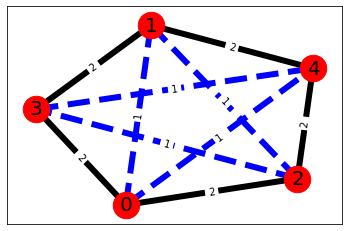

In [6]:
# Define the graph
N_vertices = 5
G = nx.Graph()

for i in range(0,N_vertices):
  for j in range(i+1,N_vertices):
    if (j-i)%3 == 1:
      G.add_edge(str(i), str(j), weight=1)
    else:
      G.add_edge(str(i), str(j), weight=2)

heavy_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 1]
light_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 1]
pos = nx.spring_layout(G, seed=11) 
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="r")
nx.draw_networkx_edges(G, pos, edgelist=heavy_edges, width=6)
nx.draw_networkx_edges(G, pos, edgelist=light_edges, width=6, edge_color="b", style="dashed")
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
      
#nx.draw(G, with_labels=True, alpha=0.8, node_size=300)



We implement the QAOA algorithm on this data set. We choose:
- Mixer Hamiltonian: $\hat{H}_M = \sum_{i=0}^{N-1} X_i$
- Problem Hamiltonin as defined above

For an approximate Trotterization with p steps, the evolution yields the following state:
\begin{equation}
|\overrightarrow{\gamma}, \overrightarrow{\beta}\rangle = e^{i\beta_p H_M} e^{i\gamma_p H_P} \cdots e^{i\beta_1 H_M} e^{i\gamma_1 H_P}|+\rangle^{\otimes{N}}
\end{equation}
where $|+\rangle^{\otimes{N}} = \frac{1}{\sqrt{2^N}} \sum_{z\in \{0,1\}^N} |z\rangle $ is an equal superposition of all bitstrings.

In [7]:
dev = qml.device("default.qubit", wires=len(G.nodes()), shots= 1024)

@qml.qnode(dev)
def QAOA_Circuit(G, weights, V, p, angles):
  N_vertices = len(G.nodes())
  wires = range(N_vertices)
  distances = nx.get_edge_attributes(G, "weight")

  # Initialize the states
  for i in range(N_vertices):
    qml.Hadamard(wires=wires[i])

  # Apply QAOA
  gammas = angles[:p]
  beta = angles[p:]

  problem_coef = []
  problem_operators = []

  for step in range(0, p):
      
  # Apply the problem Hamiltonian
    
    for i in range(0, N_vertices):
       coef_single = V*weights[i] - sum([v for k,v in distances.items() if str(i) in k])
       qml.RZ(coef_single*gammas[step], wires=wires[i])
       if step == 1:
         problem_coef += [coef_single]
         problem_operators += [qml.PauliZ(wires=wires[i])]

       for j in range(i+1, N_vertices):
         coef_double = (1/2*weights[i]*weights[j] + 1/4*nx.get_edge_attributes(G, "weight")[(str(i), str(j))])
         qml.MultiRZ(gammas[step]*coef_double, wires=[wires[i]]+[wires[j]])
         if step == 1:
           problem_coef += [coef_double]
           problem_operators += [qml.PauliZ(wires[i]) @ qml.PauliZ(wires[j])]


  # Apply the mixer Hamiltonian
    for i in range(0, N_vertices):
       qml.RX(beta[step], wires=wires[i])

    # Compute the expectation value of the problem Hamiltonian
    # problem_H = qml.Hamiltonian(problem_coef, problem_operators)

  return qml.expval(qml.Hamiltonian(problem_coef, problem_operators))


In [151]:
@qml.qnode(dev)
def QAOA_Circuit_optimized_probas(G, weights, V, p, angles):
  N_vertices = len(G.nodes())
  wires = range(N_vertices)
  distances = nx.get_edge_attributes(G, "weight")

  # Initialize the states
  for i in range(N_vertices):
    qml.Hadamard(wires=wires[i])

  # Apply QAOA
  gammas = angles[:p]
  beta = angles[p:]

  for step in range(0, p):
      
  # Apply the problem Hamiltonian
    
    for i in range(0, N_vertices):
       coef_single = V*weights[i] - sum([v for k,v in distances.items() if str(i) in k])
       qml.RZ(coef_single*gammas[step], wires=wires[i])

       for j in range(i+1, N_vertices):
         coef_double = (1/2*weights[i]*weights[j] + 1/4*nx.get_edge_attributes(G, "weight")[(str(i), str(j))])
         qml.MultiRZ(gammas[step]*coef_double, wires=[wires[i]]+[wires[j]])

  # Apply the mixer Hamiltonian
    for i in range(0, N_vertices):
       qml.RX(beta[step], wires=wires[i])

  return qml.probs(wires)

In [105]:
# Optimize the angles
def cost_function(G, weights, V, p, angles):
  def optimizable_object(angles):
    cost_exp_val = QAOA_Circuit(G, weights, V, p, angles)
    return cost_exp_val
  return optimizable_object

In [235]:
# Parameters
V = 10
weights = np.array([1,2,7,4,5], requires_grad=False)
p=2

angles = np.array(2*p*[np.pi/4], requires_grad=True)
#angles = np.pi/p*np.array(2*p*[0])
shots=1024

dev = qml.device("default.qubit", wires=len(G.nodes()), shots=shots)

In [236]:
circuit = QAOA_Circuit(G, weights, V, p, angles)

In [237]:
from scipy.optimize import minimize
cost = cost_function(G, weights, V, p, angles)
optimized_params = minimize(cost, angles, method='COBYLA')
optimized_angles = optimized_params.x

#optimizer = qml.GradientDescentOptimizer(stepsize=0.8)
#cost = cost_function(G, weights, V, p, angles)
#for k in range(100):
#    if k % 5 == 0:
#        print(f"Step {k}, cost: {cost(angles)}")
#    angles = optimizer.step(cost, angles)
#optimized_angles = angles

In [238]:
proba_opt = QAOA_Circuit_optimized_probas(G, weights, V, p, optimized_angles)
exp_val_opt = QAOA_Circuit(G, weights, V, p, optimized_angles)
#probas_opt = result(0)
#exp_val = result(1)
print(exp_val_opt)

-34.09912109375


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 <a list of 32 Text major ticklabel objects>)

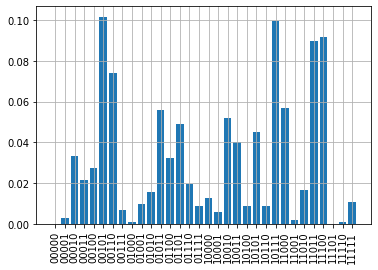

In [239]:
xlabels = [str(bin(i)[2:]) for i in range(len(proba_opt))]
for x in range(len(xlabels)):
  while len(xlabels[x])<len(xlabels[-1]):
    xlabels[x] = '0' + xlabels[x]
plt.grid()
plt.bar(xlabels, proba_opt)
plt.xticks(rotation=90)


In [240]:
print(np.max(proba_opt))

0.1015625


## Classical algorithm

In [230]:
# Brute force
def classical_cost_calculator(z, G, weights, V):
   weights = np.array(weights)
   z = np.array(list(int(z[i]) for i in range(len(z))), requires_grad=False)
   distances = nx.get_edge_attributes(G, "weight")
   cost = (V-np.dot(weights,z))**2
   for i in range(len(G.nodes())):
     for j in range(i+1, len(G.nodes())):
       cost += distances[(str(i), str(j))] * z[i] * z[j]
   return cost

def int_to_binary(G):
  N = len(G.nodes())
  n_list = list(range(2^N))

  def binary_filler(z,N):
    while len(z)<N:
      z = '0' + z
      return z
      
  z_list = [binary_filler(bin(n_list[i])[2:], N) for i in range(len(n_list))]
  return z_list

In [234]:
z = '00' + bin(5)[2:]
#classical_cost_calculator(z, G, weights, V)
z = np.array(list(int(z[i]) for i in range(len(z))))
weights = np.array(weights)
cost = classical_cost_calculator(z, G, weights, V)
cost = (V-np.dot(weights,z))**2
cost
z_list = int_to_binary(G)
z_list

NameError: ignored

In [212]:
distances = nx.get_edge_attributes(G, "weight")
distances[('0', '1')]
cost = (V-weights*z)**2
cost

tensor([100, 100,   9, 100,  25], requires_grad=True)

In [225]:
len(G.nodes())

5